In [13]:
import torch
import random
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

In [14]:
# Hyperparameters
LEARNING_RATE = 0.001 # standard for adam optimizer
EPISODES = 500 # set higher to see patterns
BATCH_SIZE = 64 # standard for xp replay batch size
GAMMA = 0.99 # high learning rate

# epsilon greedy strat
EPS_START = 1.0 
EPS_END = 0.01
EPS_DECAY = 0.995

TARGET_FREQ = 10 # uodate target network every 10 eps
REPLAY_BUFFER_SIZE = 10000 # memory cap for xp replay

In [15]:

# Experience Replay for Monte Carlo
class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, trajectory):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = trajectory
        self.position = (self.position + 1) % self.capacity
    
    # mini-batch sample
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# DQN Model
class DQN(torch.nn.Module):
    # two hidden layers, 128 neurons, input neurons = state dim, output neurons = action dim
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, output_dim)
        ) # to avoid tensor dim mismatch

    # forward pass
    def forward(self, x):
        return self.network(x)

In [16]:
# Training function with Monte Carlo rollouts
def train_dqn_monte_carlo(env, use_replay_buffer=True, train_every_2nd_episode=False):
    # network input/output
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # main/target network
    policy_net = DQN(state_dim, action_dim)
    target_net = DQN(state_dim, action_dim)

    # copy weights/biases to target from main net
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = torch.optim.Adam(policy_net.parameters(), LEARNING_RATE) # adam optimizer with 0.001 lr

    replay_buffer = ExperienceReplay(REPLAY_BUFFER_SIZE) if use_replay_buffer else None

    # Metrics
    rewards = []
    eps = EPS_START

    for episode in range(EPISODES):
        state, _ = env.reset()
        total_reward = 0
        done = False
        trajectory = []  # Store (state, action, reward) for Monte Carlo

        while not done:
            # Epsilon-greedy action selection
            if random.random() < eps:
                # explore
                action = env.action_space.sample()
            else:
                # exploit
                with torch.no_grad():
                    q_values = policy_net(torch.FloatTensor(state))
                    action = q_values.argmax().item()

            # Action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

            # Store transition
            trajectory.append((state, action, reward))
            state = next_state

        # Compute total discounted returns for Monte Carlo
        returns = []
        G = 0
        for _, _, reward in reversed(trajectory):
            G = reward + GAMMA * G
            returns.insert(0, G)

        # Update replay buffer
        if use_replay_buffer:
            replay_buffer.push(list(zip([t[0] for t in trajectory], [t[1] for t in trajectory], returns)))

        # Train the model, updates Q-network using monte carlo returns
        if use_replay_buffer and len(replay_buffer) >= BATCH_SIZE:
            if not train_every_2nd_episode or (episode % 2 == 1):
                sampled_trajectories = replay_buffer.sample(BATCH_SIZE)
                states, actions, returns = [], [], []
                for traj in sampled_trajectories:
                    states.extend([t[0] for t in traj])
                    actions.extend([t[1] for t in traj])
                    returns.extend([t[2] for t in traj])

                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions)
                returns = torch.FloatTensor(returns)

                # Compute Q-values
                current_q = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()

                # Compute loss and optimize
                loss = torch.nn.MSELoss()(current_q, returns)
                optimizer.zero_grad() # clear grads
                loss.backward() # calculate grads
                optimizer.step() # update

        # Update target network
        if episode % TARGET_FREQ == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Decay epsilon
        eps = max(EPS_END, eps * EPS_DECAY) # update epsilon

        # Record metrics
        rewards.append(total_reward)
        print(f"Episode {episode + 1}/{EPISODES}, Reward: {total_reward}, Epsilon: {eps:.2f}")

    return rewards


In [17]:
# Graphs
def plot_rewards(rewards_with_buffer, rewards_without_buffer, rewards_with_buffer_2nd):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards_with_buffer, label="With Replay Buffer")
    plt.plot(rewards_without_buffer, label="Without Replay Buffer")
    plt.plot(rewards_with_buffer_2nd, label="With Replay Buffer (Every 2nd Episode)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("DQN Training Performance with Monte Carlo Rollouts")
    plt.legend()
    plt.show()

Training with replay buffer and Monte Carlo rollouts...
Episode 1/500, Reward: 15.0, Epsilon: 0.99
Episode 2/500, Reward: 78.0, Epsilon: 0.99
Episode 3/500, Reward: 19.0, Epsilon: 0.99
Episode 4/500, Reward: 19.0, Epsilon: 0.98
Episode 5/500, Reward: 19.0, Epsilon: 0.98
Episode 6/500, Reward: 12.0, Epsilon: 0.97
Episode 7/500, Reward: 15.0, Epsilon: 0.97
Episode 8/500, Reward: 18.0, Epsilon: 0.96
Episode 9/500, Reward: 42.0, Epsilon: 0.96
Episode 10/500, Reward: 15.0, Epsilon: 0.95
Episode 11/500, Reward: 24.0, Epsilon: 0.95
Episode 12/500, Reward: 11.0, Epsilon: 0.94
Episode 13/500, Reward: 12.0, Epsilon: 0.94
Episode 14/500, Reward: 14.0, Epsilon: 0.93
Episode 15/500, Reward: 38.0, Epsilon: 0.93
Episode 16/500, Reward: 22.0, Epsilon: 0.92
Episode 17/500, Reward: 15.0, Epsilon: 0.92
Episode 18/500, Reward: 16.0, Epsilon: 0.91
Episode 19/500, Reward: 20.0, Epsilon: 0.91
Episode 20/500, Reward: 17.0, Epsilon: 0.90
Episode 21/500, Reward: 39.0, Epsilon: 0.90
Episode 22/500, Reward: 33.0,

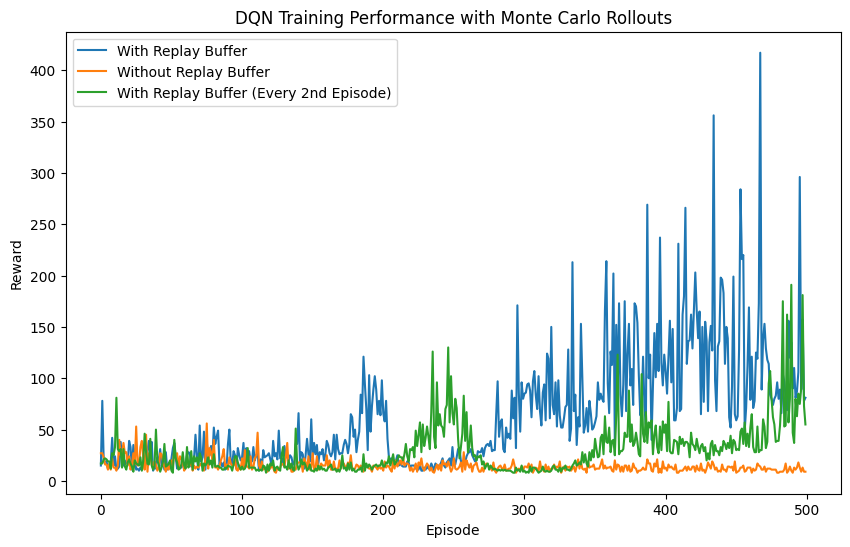

In [18]:

# Main (train and plot)
if __name__ == "__main__":
    env = gym.make("CartPole-v1")

    # Train with replay buffer
    print("Training with replay buffer and Monte Carlo rollouts...")
    rewards_with_buffer = train_dqn_monte_carlo(env, use_replay_buffer=True)

    # Train without replay buffer
    print("Training without replay buffer and Monte Carlo rollouts...")
    rewards_without_buffer = train_dqn_monte_carlo(env, use_replay_buffer=False)

    # Train with replay buffer, updating every 2nd episode
    print("Training with replay buffer and Monte Carlo rollouts (every 2nd episode update)...")
    rewards_with_buffer_2nd = train_dqn_monte_carlo(env, use_replay_buffer=True, train_every_2nd_episode=True)

    # Plot results
    plot_rewards(rewards_with_buffer, rewards_without_buffer, rewards_with_buffer_2nd)

### Summary
Experience Replay boosts the rewards (accuracy) by quite a lot, skipping every 2nd episode with experience replay was did outperform the normal experince replay model occasionally. Though trends are clear there still seems to be some instability, could adjust the target network and experience replay to make it more stable.